# Sparse Hebbian Learning: basics

We are interested here in learning the "optimal" components of a set of images (let's say some "natural", usual images). As there is no supervisor to guide the learning, this is called unsupervised learning. Our basic hypothesis to find the best ("optimal") components will be to assume that *a priori* the most sparse is more plausible. We will implement the derived algorithm in this set of scripts.

Here, we will show the basic operations that are implemented in this package. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=4, suppress=True)

## experiments

To test and control for the role of different parameters, we will have a first object (in the [shl_experiments.py](https://github.com/bicv/SHL_scripts/blob/master/shl_scripts/shl_experiments.py) script) that controls a learning experiment. It contains all relevant parameters, but can also keep a trace of the history of some statistics. This is useful to compare the relative efficiency of the different solutions.


In [3]:
DEBUG_DOWNSCALE, verbose = 10, 0
DEBUG_DOWNSCALE, verbose = 1, 0
DEBUG_DOWNSCALE, verbose = 10, 10
DEBUG_DOWNSCALE, verbose = 1, 10
matname = 'quantization'

In [4]:
from shl_scripts.shl_experiments import SHL
opts = dict(DEBUG_DOWNSCALE=DEBUG_DOWNSCALE, verbose=verbose, homeo_method='HEH')
shl = SHL(**opts)
data = shl.get_data(matname='data')

Extracting data..loading the data called : /tmp/data_cache/data_data
Data is of shape : (81920, 576) - done in 0.28s.


In [5]:
!ls -l {shl.data_cache}/{matname}*

-rw-r--r--  1 lolo  wheel        0 Jan 19 14:07 /tmp/data_cache/quantization_coding.npy_lock
-rw-r--r--  1 lolo  wheel        0 Jan 19 14:07 /tmp/data_cache/quantization_coding.npy_lock_pid-13675_host-ada
-rw-r--r--  1 lolo  wheel  1825956 Jan 19 14:06 /tmp/data_cache/quantization_dico.pkl


In [6]:
!ls -l {shl.data_cache}/{matname}*

-rw-r--r--  1 lolo  wheel        0 Jan 19 14:07 /tmp/data_cache/quantization_coding.npy_lock
-rw-r--r--  1 lolo  wheel        0 Jan 19 14:07 /tmp/data_cache/quantization_coding.npy_lock_pid-13675_host-ada
-rw-r--r--  1 lolo  wheel  1825956 Jan 19 14:06 /tmp/data_cache/quantization_dico.pkl


In [7]:
print('number of patches, size of patches = ', data.shape)
print('average of patches = ', data.mean(), ' +/- ', data.mean(axis=1).std())
SE = np.sqrt(np.sum(data**2, axis=1))
print('average energy of data = ', SE.mean(), '+/-', SE.std())

number of patches, size of patches =  (81920, 576)
average of patches =  -0.00012084077288875488  +/-  0.03859985466733349
average energy of data =  15.406568625692532 +/- 13.07862508376865


In [8]:
shl.do_precision

False

## learning

The actual learning is done in a second object (here ``dico``) from which we can access another set of properties and functions  (see the [shl_learn.py](https://github.com/bicv/SHL_scripts/blob/master/shl_scripts/shl_learn.py) script):

loading the dico called : /tmp/data_cache/quantization_dico.pkl


/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


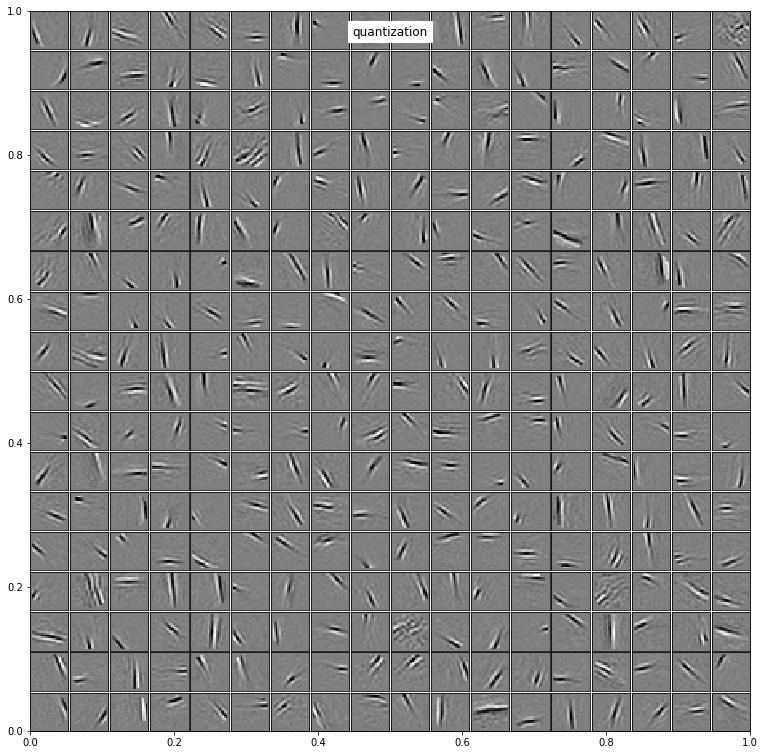

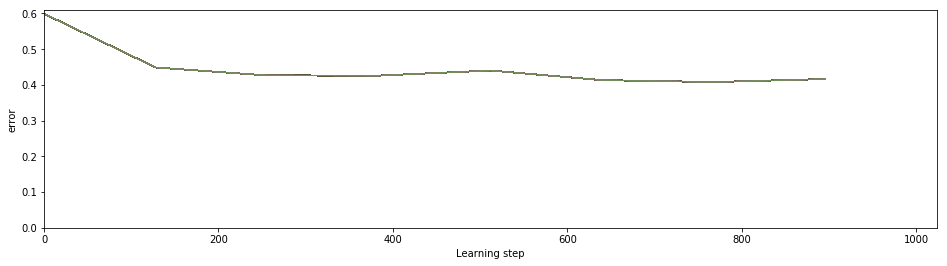

In [9]:
list_figures = ['show_dico', 'time_plot_error']#, 'plot_variance',  'plot_variance_histogram',  'time_plot_prob',  'time_plot_kurt',  'time_plot_var']

dico = shl.learn_dico(data=data, list_figures=list_figures, matname=matname)

In [10]:
print('size of dictionary = (number of filters, size of imagelets) = ', dico.dictionary.shape)
print('average of filters = ',  dico.dictionary.mean(axis=1).mean(), 
      '+/-',  dico.dictionary.mean(axis=1).std())
SE = np.sqrt(np.sum(dico.dictionary**2, axis=1))
print('average energy of filters = ', SE.mean(), '+/-', SE.std())

size of dictionary = (number of filters, size of imagelets) =  (324, 576)
average of filters =  8.145335037571311e-05 +/- 0.0008928288221214216
average energy of filters =  1.0 +/- 8.136026394744311e-17


## coding

The learning itself is done via a gradient descent but is highly dependent on the coding / decoding algorithm. This belongs to a another function (in the [shl_encode.py](https://github.com/bicv/SHL_scripts/blob/master/shl_scripts/shl_encode.py) script)

In [15]:
from shl_scripts.shl_encode import mp
nb_quant = 100
#sparse_code = shl.code(data, dico, matname=matname)
P_cum_zeroeffect = np.linspace(0, 1, nb_quant, endpoint=True)[np.newaxis, :] * np.ones((shl.n_dictionary, 1))
P_cum = dico.P_cum
P_cum = None
l0_sparseness = 200
l0_sparseness = shl.l0_sparseness
sparse_code = mp(data, dico.dictionary, l0_sparseness=l0_sparseness, P_cum=P_cum)

print('number of codes, size of codewords = ', sparse_code.shape)
print('average of codewords = ', sparse_code.mean())
print('l0-sparseness of codewords = ', (sparse_code>0).mean(), ' ~= l0/M =', shl.l0_sparseness/shl.n_dictionary)
print('average energy of codewords = ', sparse_code.std(axis=0).mean())
print('std of the average of individual patches = ', sparse_code.mean(axis=0).std())

number of codes, size of codewords =  (81920, 324)
average of codewords =  0.015714654847325857
l0-sparseness of codewords =  0.025919860086323302  ~= l0/M = 0.04938271604938271
average energy of codewords =  0.8772046066252224
std of the average of individual patches =  0.006029847736526323


In [16]:
patches = sparse_code @ dico.dictionary
print('number of codes, size of reconstructed images = ', patches.shape)

number of codes, size of reconstructed images =  (81920, 576)


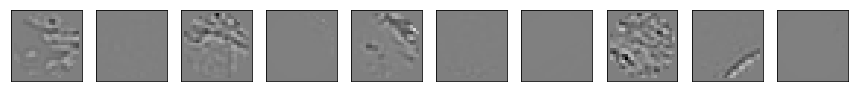

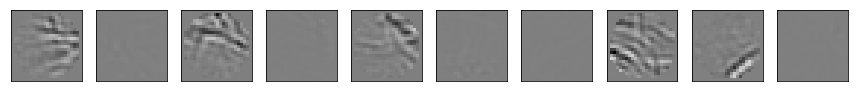

In [22]:
from shl_scripts.shl_tools import show_data
max_patches = 10
fig, axs = show_data(data[:max_patches, :])
fig, axs = show_data(patches[:max_patches, :])


average of data patches =  -0.00012084077288875488 +/- 0.03859985466733349
average of residual patches =  -0.0007569468971871618 +/- 0.03640733716180979
average energy of data =  0.6419403594038553 +/- 0.5449427118236937
average energy of residual =  0.39720072021940767 +/- 0.3346179038326238


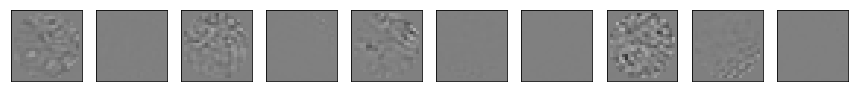

In [24]:
error = data - patches
fig, axs = show_data(error[:max_patches, :], cmax=np.max(np.abs(data[:max_patches, :])))
print('average of data patches = ', data.mean(), '+/-', data.mean(axis=1).std())
print('average of residual patches = ', error.mean(), '+/-', error.mean(axis=1).std())
SE = np.sqrt(np.mean(data**2, axis=1))
print('average energy of data = ', SE.mean(), '+/-', SE.std())
SE = np.sqrt(np.mean(error**2, axis=1))
print('average energy of residual = ', SE.mean(), '+/-', SE.std())

## Version used

In [14]:
%load_ext version_information
%version_information numpy, shl_scripts

Software versions
Python 3.6.4 64bit [GCC 4.2.1 Compatible Apple LLVM 9.0.0 (clang-900.0.39.2)]
IPython 6.2.1
OS Darwin 17.3.0 x86_64 i386 64bit
numpy 1.14.0
shl_scripts 20171221
Fri Jan 19 14:34:27 2018 CET